# Clasificación de imágenes usando redes profundas con Keras

El siguiente Notebook está copiado literalmente (sólo lo tradujimos) de [Kaggle](https://www.kaggle.com/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy/notebook
), una comunidad online que comenzó organizando "competencias" de Machine Learning. En 2017 fue comprada por Google y hyoy en dia tambien es una plataforma para bases de datos, recursos educativos y más.


## El sistema y su implementación

El problema en cuestión incluye todos los pasos típicos de un sistema de aprendizaje automático:

*   [Preámbulo](#preambulo)
*   [Lectura de los datos](#lectura)
*   [Visualización previa exploratoria](#visualizacion)
*   [Preprocesamiento](#preprocesamiento)
*   [Modelado](#modelado)
*   [Evaluación](#evaluacion)

El modelo en este caso es una _red neuronal profunda_. Este tipo de redes requieren bibliotecas especializadas que permiten hacer los cálculos en tiempos razonables. En particular, veremos la diferencia dramática que implica utilizar una GPU en lugar de la CPU del sistema.

Más abajo veremos detalles sobre la red neuronal en sí.


<a id="preambulo"></a>
## Preámbulo


In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

<a id="lectura"></a>

## Los datos

El problema en cuestión implica identificar a qué clase pertenece una pequeña imagen color de 32x32 pixeles.

El CIFAR-10 (Canadian Institute For Advanced Research) es una colección de imágenes usadas muy comunmente para entrenar sistemas de aprendizaje automático para visión por computadora (Computer Vision). Contiene 60000 imágenes a color de 32x32 pixeles en las cuales aparecen objetos de 10 categorías (de ahí viene el 10, también hay de 100): aviones, autos, gatos, perros, etc. Hay 6000 imágenes de cada clase, es decir, está perfectamente balanceada.

Al igual que `sklearn`, el paquete `keras` incluye varios datasets interesantes para experimentar. El CIFAR-10 es uno de ellos.

Además de lo anterior, Keras incluye muchos modelos preentrenados para probar.

In [2]:
#
# lectura de los datos
#
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


<a id="visualizacion"></a>
## Visualización Exploratoria 

Vamos a mirar un poco los datos.
Las matrices de imagen tienen *cuatro* índices: 
1.   cantidad de muestras (imágenes)
1.   cantidad de filas de la imagen de muestra
1.   cantidad de columnas de la imagen de muestra
1.   cantidad de _canales de color_ de la imagen de muestra

Cabe recordar que las imágenes a color tienen _tres_ índices, el último indica el canal de color. Lo más común es 3: rojo (0), verde (1) y azul (2).


In [3]:
#
# dimensiones
#
print('\nTamaños:')
print('\timágenes de entrenamiento :',train_images.shape)
print('\tetiquetas de entrenamiento:',train_labels.shape)
print('\tetiquetas de evaluación   :',test_images.shape)
print('\tetiquetas de evaluación   :',test_labels.shape)


Tamaños:
	imágenes de entrenamiento : (50000, 32, 32, 3)
	etiquetas de entrenamiento: (50000, 1)
	etiquetas de evaluación   : (10000, 32, 32, 3)
	etiquetas de evaluación   : (10000, 1)


In [4]:
# 
# veamos la cantidad de clases en cada conjunto 
# (deberían ser 10: del 0 al 9)
# 
print('clases presentes en conj. de entrenamiento:',np.unique(train_labels))
print('clases presentes en conj. de evaluación   :',np.unique(test_labels))

clases presentes en conj. de entrenamiento: [0 1 2 3 4 5 6 7 8 9]
clases presentes en conj. de evaluación   : [0 1 2 3 4 5 6 7 8 9]


In [5]:
#
# le ponemos nombre a las clases 
#
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

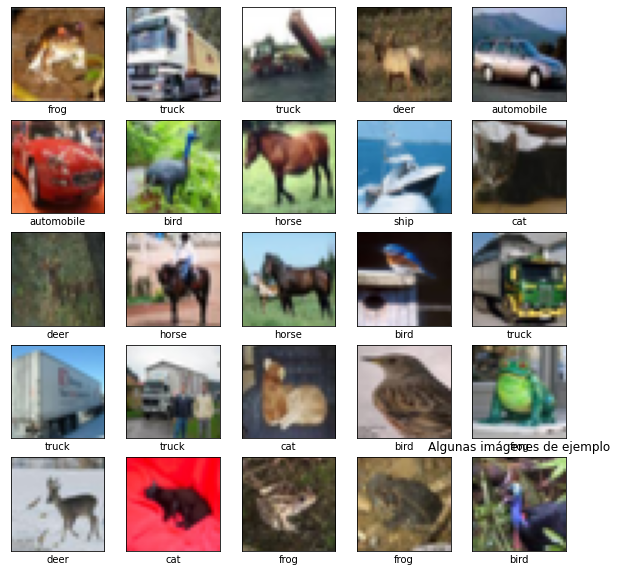

In [6]:
#
# veamos algunas de las imágenes
# 
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])
plt.title('Algunas imágenes de ejemplo')
plt.show()

<a id="preprocesamiento"></a>
## Preprocesamiento de los datos

Para este problema, hacemos lo siguiente:

*   Normalizamos los valores de los pixeles de las imágenes entre 0 y 1 (vienen entre 0 y 255)
*   Codificamos las clases usando _one hot encoding_, como ya vimos


In [7]:
#
# hacemos que los pixeles pasen a ser valores con decimales (float)
# (cuando los cargamos, son enteros)
#
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
#
# una vez convertidos a decimales, los dividimos para
# que el mayor valor sea 1
#
train_images = train_images / 255
test_images = test_images / 255 
#
# usamos one-hot encoding para representar cada clase
# con un vector binario. Recordar que el one-hot-encoding
# lo que hace es convertir la clase 'i' en un vector
# con todos los valores a cero (10 en este caso) menos uno, 
# que vale 1 en el lugar 'i'
#
# o sea que la clase 1 se convierte en el vector [1,0,0,0,0,0,0,0,0,0]
#
num_classes = 10
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

<a id="modelado"></a>

## Construcción del modelo

Para esto utilizamos el paquete `Keras`. Keras es un subpaquete de `TensorFlow`, el sistema abierto de diseño e implementación de redes profundas de alto desempeño desarrollado y mantenido por Google. 

TensorFlow  permite utilizar tarjetas gráficas (GPUs) para acelerar enormemente los cálculos.

La idea de Keras es facilitar el uso de este tipo de tecnologías a personas con poca formación técnica en matemáticas, ingeniería, computación y/o aprendizaje automático.

Para entender la arquitectura de la red, hay que familiarizarse con los distintos tipos de _capas_ que pueden tener este tipo de sistemas. No vamos a entrar en los detalles en este curso, pero pueden averiguarlo en Internet. Hay muchísimos tutoriales y explicaciones muy amenas al respecto.
De todos modos, lo listamos abajo para referencia:

*   Las primeras capas se organizan en  seis grupos siguiendo un esquema típico de redes _convolucionales_. Su rol es el de construir una _representación resumida_ de los datos de la imagen. 
*   Cada grupo termina con una etapa de _regularización_ llamada _dropout_; eso no es una capa en sí, sino que borra neuronas al azar para que el modelo no tenga tantos parámetros
*   Las capas _batch normalization_ son auxiliares también; la idea es que _re-normalizan_ los datos previo al ingreso a la siguiente capa, para que la capa funcione mejor (al igual que es bueno normalizar antes de cualquier método de aprendizaje automático)
*   La última capa, es una capa de neuronas _comunes_, como las que vimos en el práctico anterior, también llamadas _densas_. Esa es la capa que termina tomando la decisión.
*   La salida _softmax_ es para transform la decisión al formato _one hot encoding_.




In [8]:
# Creating a sequential model and adding layers to it

model = Sequential()
#
# primer grupo de convoluciones
#
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
#
# segundo grupo de convoluciones
#
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
#
# pseudo-capa de regularización
#
model.add(layers.Dropout(0.3))

#
# tercer grupo de convoluciones
#
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
#
# cuarto grupo de convoluciones
#
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
#
# y más regularización
#
model.add(layers.Dropout(0.5))

#
# quinto grupo de convoluciones
#
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
#
# sexto grupo de convoluciones
#
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
#
# y más regularización
#
model.add(layers.Dropout(0.5))
# 
# capa final densa
#
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
# 
# y más regularización
#
model.add(layers.Dropout(0.5))
# 
# capa softmax, para convertir a one-hot-encoding
#
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10
#
# esto nos muestra el modelo que constriumos hasta el momento
#
model.summary()
#
# esto "compila" o "arma" el modelo, y define algunos aspectos técnicos
# como el método de optimización a utilizar (ADAM), el tipo de función de costo, 
# y otros aspectos en los que no vamos a entrar.
#
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

<a id="ajuste"></a>
### Ajuste del modelo

Ahora sí, entrenamos el modelo.

Para que esto corra en un tiempo razonable, hay que ir al menú `Entorno de Ejecución` de colab,  seleccionar `Cambiar el tipo de entornode ejecución` y luego elegir `GPU`. Eso hace que corra unas 100 veces más rápido (de unos minutos a unas horas).

En el momento de entrenar se especifican aún más parámetros que tienen que ver con cómo se presentan los datos al entrenador:

* `batch_size` es cuántas imágenes se le presentan a la vez al algoritmo de entrenamiento (optimización) antes de dar un paso para mejorar al sistema
* `epochs` (épocas) es cuántas vueltas vamos a dar sobre todo el conjunto de datos antes de terminar el entrenamiento.


In [ ]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=100,validation_data=(test_images, test_labels))

Epoch 1/100
782/782 [==============================] - 18s 12ms/step - loss: 1.7228 - accuracy: 0.4066 - val_loss: 1.3242 - val_accuracy: 0.5249
Epoch 2/100
782/782 [==============================] - 9s 12ms/step - loss: 1.1771 - accuracy: 0.5801 - val_loss: 1.1805 - val_accuracy: 0.5880
Epoch 3/100
782/782 [==============================] - 9s 12ms/step - loss: 0.9807 - accuracy: 0.6546 - val_loss: 0.9189 - val_accuracy: 0.6742
Epoch 4/100
782/782 [==============================] - 10s 13ms/step - loss: 0.8822 - accuracy: 0.6902 - val_loss: 0.7543 - val_accuracy: 0.7361
Epoch 5/100
782/782 [==============================] - 8s 11ms/step - loss: 0.8110 - accuracy: 0.7173 - val_loss: 0.7245 - val_accuracy: 0.7503
Epoch 6/100
782/782 [==============================] - 8s 10ms/step - loss: 0.7499 - accuracy: 0.7398 - val_loss: 1.2070 - val_accuracy: 0.6143
Epoch 7/100
782/782 [==============================] - 9s 11ms/step - loss: 0.7093 - accuracy: 0.7560 - val_loss: 0.6990 - val_accurac

<a id="evaluacion"></a>
## Evaluación

### Calidad del entrenamiento

Primero veremos cómo fue variando  el _accuracy_  del sistema en entrenamiento y en validación a medida que avanzaron las iteraciones. Esto es importante para verificar que no esté ocurriendo underfitting u overfitting.


In [ ]:
#
# Accuracy 
#
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

### Desempeño

Veamos ahora algunas cuantas imágenes y comparemos el resultado que obtuvimos con la red versus su clase correcta.


In [ ]:
# 
# aplicamos el modelo a las imágenes de evaluación
#
pred = model.predict(test_images)
#
# desarmamos el one-hot encoding
#
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)
#
# mostramos los resultados
#
fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()
for i in np.arange(0, 25):
    axes[i].imshow(test_images[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(test_labels[i])], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)